In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Making a folder in Drive, to extract Dataset in it.
!mkdir "drive/My Drive/intel-image-classification"

In [ ]:
# Unzipping Intel Image Dataset .zip file into desired directory
!unzip -q "drive/My Drive/intel-image-classification.zip" -d "drive/MyDrive/intel-image-classification"
print('Files unzipped successfully!')

Files unzipped successfully!


In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 13.2MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
# import tqdm

# # quietly deep-reload tqdm
# import sys
# from IPython.lib import deepreload 

# stdout = sys.stdout
# sys.stdout = open('junk','w')
# deepreload.reload(tqdm)
# sys.stdout = stdout

# tqdm.__version__

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import preprocess_input
import numpy as np
import tqdm

In [4]:
#Paths for Training, Validation and Testing Dataset
train_dir = "drive/My Drive/intel-image-classification/seg_train"
pred_dir = "drive/My Drive/intel-image-classification/seg_test"
test_dir = "drive/My Drive/intel-image-classification/seg_pred"

In [5]:
B_S = 64; #Batch Size
E = 10;   #No. of Epochs

train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

x_train = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = B_S,
        # shuffle = False,
        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.


In [6]:
pred_datagen = ImageDataGenerator(rescale=1. /255)

x_valid = pred_datagen.flow_from_directory(
        pred_dir,
        target_size = (150, 150),
        batch_size = B_S,
        # shuffle = False,
        class_mode = 'categorical')

Found 3000 images belonging to 6 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

x_test = test_datagen.flow_from_directory(
        test_dir,
        target_size = (150, 150),
        batch_size = B_S,
        # shuffle = False,
        class_mode = 'categorical')

Found 7301 images belonging to 6 classes.


In [52]:
#VGG16 Classifier
model = VGG16(
    include_top=True, weights=None,
    input_shape=(150, 150, 3), pooling=None, classes=6,
    classifier_activation='softmax'
    # input_tensor=Input(shape=(150, 150, 3))
)

In [53]:
from keras.optimizers import SGD
I_LR = 0.01
sgd = SGD(lr= I_LR, decay= 1e-7, momentum=.9)
# sgd = SGD(lr= I_LR, decay= I_LR/E, momentum=.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

###3rd Try

In [41]:
# # This function keeps the initial learning rate for the first ten epochs
# # and decreases it exponentially after that.
# def scheduler(epoch, lr):
#   if epoch < 5:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

In [16]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.2,
                                                   patience=5, 
                                                   min_lr=0.001)

In [55]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# train the model with tqdm_callback
# make sure to set verbose = 0 to disable the default progress bar.
H = model.fit(x = x_train,
          batch_size = B_S,
          # steps_per_epoch = math.ceil(len(x_train)/B_S),
          epochs = E,
          # shuffle = False,
          callbacks = [tqdm_callback,lr_callback],
          validation_data = x_valid,
          verbose = 0
          )

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [56]:
# save the model's trained weights
model.save_weights('drive/My Drive/vgg16_trained_wts3.h5')

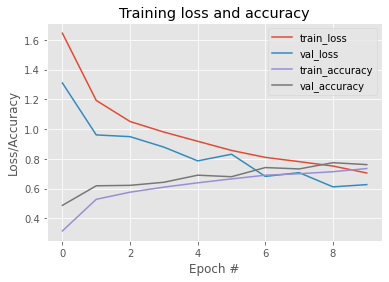

In [57]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, E)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [58]:
score = model.evaluate(x = x_test,
          batch_size = B_S,
          callbacks = [tqdm_callback],
          verbose=0
          )
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])


Test Loss =  0.6217626929283142
Test Accuracy =  0.7644158601760864


In [59]:
import pandas as pd    
#function to Construct Confusion Matrix"
def constructConfusionMatrix(actual_labels,predicted_labels):
  """
  # This function takes actual labels and predicted labels
  # and constructs a confusion matrix
  # Args:
  #   predicted_labels: predicted labels (numpy array)
  #   actual_labels: actual labels (numpy array) 

  # Returns:
  #   Data Frame depicting a Confusion Matrix (3x3 Matrix for 2 classes)

  """
  act = pd.Series(actual_labels,name='Actual')
  pred = pd.Series(predicted_labels,name='Predicted')
  confusion_matrix = pd.crosstab(act, pred, margins=True)
  print("Confusion matrix:\n%s" % confusion_matrix)
  return confusion_matrix

In [60]:
#@title Default title text
print("\n", x_test.class_indices, "\n")
cmSVC = constructConfusionMatrix(y_true,y_test)


 {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5} 

Confusion matrix:
Predicted     0     1     2     3    4     5   All
Actual                                            
0           223   232   197   252   62   178  1144
1           224   232   182   269   58   201  1166
2           279   264   203   314   71   199  1330
3           271   267   211   292   54   202  1297
4           221   200   198   250   66   193  1128
5           236   232   197   301   70   200  1236
All        1454  1427  1188  1678  381  1173  7301


###Transfer Learning

In [22]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [23]:
# load VGG16 model without classification layers
model2 = VGG16(include_top=False, input_shape=(150, 150, 3))

In [24]:
# add new classification layers
flat1 = Flatten()(model2.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [25]:
# define the new model
model_2 = Model(inputs=model2.inputs, outputs=output)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [26]:
from keras.optimizers import SGD
sgd_2 = SGD(lr=0.001, decay=1e-7, momentum=.9)
model_2.compile(loss='categorical_crossentropy', 
              optimizer=sgd_2,
              metrics=['accuracy'])

In [ ]:
# H2 = model.fit(X_train, y_train, batch_size=128,
#               epochs=10, 
#               validation_data=(X_valid, y_valid))

In [27]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()
# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# train the model with tqdm_callback
# make sure to set verbose = 0 to disable the default progress bar.
H = model_2.fit(x = x_train,
          batch_size = B_S,
          epochs = E,
          # shuffle = False,
          callbacks = [tqdm_callback],
          validation_data = x_valid,
          verbose = 0
          )

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [37]:
# save the model's trained weights
model_2.save_weights('/content/drive/MyDrive/Assignment-3/vgg_transfer_trained_wts.h5')

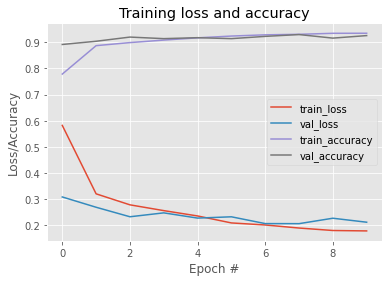

In [30]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, E)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y = model_2.predict_generator(x_test,
                            callbacks = [tqdm_callback],
                            verbose=0)
y_test = np.argmax(Y, axis=1)
y_true = x_test.classes
# print('\n Confusion Matrix \n')
# print(confusion_matrix(y_true, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
score = model_2.evaluate(x = x_test,
          batch_size = B_S,
          callbacks = [tqdm_callback],
          verbose=0
          )
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

In [ ]:
#@title Default title text
print("\n", x_test.class_indices, "\n")
cmSVC = constructConfusionMatrix(y_true,y_test)